<a href="https://colab.research.google.com/github/WickedSero/NeuralNetworks/blob/main/3_dense_sentiment_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dense Sentiment Classifier

#### Zaprojektujmy gęstą sieć do klasyfikacji sentymentu (nastroju / nastawienia) recenzji filmów z portalu IMDB

#### Załadujmy zależności (zwróć uwagę na nowy rodzaj warstwy - Embedding)

In [ ]:
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score, roc_curve, auc, RocCurveDisplay
import pandas as pd
import matplotlib.pyplot as plt
%load_ext tensorboard

**Ustawmy stałe i hiperparametry (gdy wiemy, że przetwarzanie zbioru danych będzie bardziej złożone, warto to robić już na początku), wybierz dowolną liczbę epok i batch_size. Przypatrz się co oznaczają wszystkie hiperparametry, przyda się to w zrozumieniu całego procesu przetwarzania**

In [ ]:
output_dir = 'output' #sieć będzie generować wyjście, więc określamy jego lokalizację

#hiperparametry treningu
epochs = 11
batch_size = 500

# hiperparametry przetwarzania tekstu:
n_dim = 64 #liczba wymiarów przestrzeni wektorów słów
n_unique_words = 5000 # liczba uwzględnianych najpopularniejszych słów w korpusie recenzji filmów
n_words_to_skip = 50 # liczba najczęstszych stop words do usunięcia
max_review_length = 100 # długość recenzji, dłuższe będą przycinane, a krótsze sztucznie wydłużane (tak jakby padding)
pad_type = trunc_type = 'pre' #przycinanie i wydłużanie będzie miało miejsce na początku recenzji (alternatywa do 'post')

# hiperparametry sieci:
n_dense = 64
dropout = 0.5

#### Załadujmy dane

Zbiór składa się z 50 000 recenzji - połowa w zbiorze treningowym, połowa w walidacyjnym. Wraz z recenzją dodawane są liczby gwiazdek jako oceną od 1 do 10. Recenzję ocenioną na <=4 gwiazdki uznaje się za negatywną (y=0), a na >=7 gwiazdek za pozytywną (y=1), neutralnych recenzji nie ma w zbiorze.

W metodzie `load_data` kryje się już kilka metod automatycznego przetwarzania tekstu:
 - tokenizacja
 - usuwanie znaków interpunkcyjnych
 - zamiana na małe litery
 - zamiana słów na całkowitoliczbowe indeksy
 - ograniczenie wielkości słownika (num_words)
 - usunięcie najpopularniejszych stop words (skip_top)
 - brakuje w niej ewentualnego stemmingu i lematyzacji oraz analizy n-gramów

In [ ]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words, skip_top=n_words_to_skip)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


#### Wyświetlmy pierwsze recenzje ze zbioru treningowego

Tokeny są reprezentowane przez całkowitoliczbowe indeksy, posortowane wg częstości występowania. Pierwsze kilka liczb ma specjalne znaczenie:
 - 0 - token dopełniający
 - 1 - token startowy (początek recenzji), ale tutaj jest to token nieznany gdyż token startowy znajduje się wśród 50 najpopularniejszych tokenów
 - 2 - token występujący bardzo często (czyli usunięty jako stop word) lub bardzo rzadko (czyli nieuwzględniony), zastąpiony w związku z tym tokenem 'nieznany' (UNK)
 - 3 - słowo które występuje w korpusie najczęściej
 - 4 - drugie najczęściej występujące słowo
 - 5 - trzecie najczęściej występujące słowo itd.

In [ ]:
x_train[0:6]

array([list([2, 2, 2, 2, 2, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 2, 173, 2, 256, 2, 2, 100, 2, 838, 112, 50, 670, 2, 2, 2, 480, 284, 2, 150, 2, 172, 112, 167, 2, 336, 385, 2, 2, 172, 4536, 1111, 2, 546, 2, 2, 447, 2, 192, 50, 2, 2, 147, 2025, 2, 2, 2, 2, 1920, 4613, 469, 2, 2, 71, 87, 2, 2, 2, 530, 2, 76, 2, 2, 1247, 2, 2, 2, 515, 2, 2, 2, 626, 2, 2, 2, 62, 386, 2, 2, 316, 2, 106, 2, 2, 2223, 2, 2, 480, 66, 3785, 2, 2, 130, 2, 2, 2, 619, 2, 2, 124, 51, 2, 135, 2, 2, 1415, 2, 2, 2, 2, 215, 2, 77, 52, 2, 2, 407, 2, 82, 2, 2, 2, 107, 117, 2, 2, 256, 2, 2, 2, 3766, 2, 723, 2, 71, 2, 530, 476, 2, 400, 317, 2, 2, 2, 2, 1029, 2, 104, 88, 2, 381, 2, 297, 98, 2, 2071, 56, 2, 141, 2, 194, 2, 2, 2, 226, 2, 2, 134, 476, 2, 480, 2, 144, 2, 2, 2, 51, 2, 2, 224, 92, 2, 104, 2, 226, 65, 2, 2, 1334, 88, 2, 2, 283, 2, 2, 4472, 113, 103, 2, 2, 2, 2, 2, 178, 2]),
       list([2, 194, 1153, 194, 2, 78, 228, 2, 2, 1463, 4369, 2, 134, 2, 2, 715, 2, 118, 1634, 2, 394, 2, 2, 119, 954, 189, 102, 2, 20

#### Wyświetlmy długość pierwszych recenzji (liczbę tokenów w nich) oraz ich sentyment

In [ ]:
for x in x_train[0:6]:
    print(len(x))

218
189
141
550
147
43


In [ ]:
y_train[0:6]

array([1, 0, 0, 1, 0, 0])

#### Sprawdźmy jak de facto wyglądają słowa, kryjące się pod indeksami

In [ ]:
word_index = tensorflow.keras.datasets.imdb.get_word_index()
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2

1641221/1641221 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
word_index

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

**Zadanie 0. Stwórz odwrotność powyższego słownika, by móc odczytywać recenzje**

In [ ]:
inverted_word_index = {v: k for k, v in word_index.items()}

In [ ]:
inverted_word_index

{34704: 'fawn',
 52009: 'tsukino',
 52010: 'nunnery',
 16819: 'sonja',
 63954: 'vani',
 1411: 'woods',
 16118: 'spiders',
 2348: 'hanging',
 2292: 'woody',
 52011: 'trawling',
 52012: "hold's",
 11310: 'comically',
 40833: 'localized',
 30571: 'disobeying',
 52013: "'royale",
 40834: "harpo's",
 52014: 'canet',
 19316: 'aileen',
 52015: 'acurately',
 52016: "diplomat's",
 25245: 'rickman',
 6749: 'arranged',
 52017: 'rumbustious',
 52018: 'familiarness',
 52019: "spider'",
 68807: 'hahahah',
 52020: "wood'",
 40836: 'transvestism',
 34705: "hangin'",
 2341: 'bringing',
 40837: 'seamier',
 34706: 'wooded',
 52021: 'bravora',
 16820: 'grueling',
 1639: 'wooden',
 16821: 'wednesday',
 52022: "'prix",
 34707: 'altagracia',
 52023: 'circuitry',
 11588: 'crotch',
 57769: 'busybody',
 52024: "tart'n'tangy",
 14132: 'burgade',
 52026: 'thrace',
 11041: "tom's",
 52028: 'snuggles',
 29117: 'francesco',
 52030: 'complainers',
 52128: 'templarios',
 40838: '272',
 52031: '273',
 52133: 'zaniacs',

#### Odczytajmy pierwszą z recenzji, indeksowo, a potem słownie

In [ ]:
x_train[0]

[2,
 2,
 2,
 2,
 2,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 2,
 173,
 2,
 256,
 2,
 2,
 100,
 2,
 838,
 112,
 50,
 670,
 2,
 2,
 2,
 480,
 284,
 2,
 150,
 2,
 172,
 112,
 167,
 2,
 336,
 385,
 2,
 2,
 172,
 4536,
 1111,
 2,
 546,
 2,
 2,
 447,
 2,
 192,
 50,
 2,
 2,
 147,
 2025,
 2,
 2,
 2,
 2,
 1920,
 4613,
 469,
 2,
 2,
 71,
 87,
 2,
 2,
 2,
 530,
 2,
 76,
 2,
 2,
 1247,
 2,
 2,
 2,
 515,
 2,
 2,
 2,
 626,
 2,
 2,
 2,
 62,
 386,
 2,
 2,
 316,
 2,
 106,
 2,
 2,
 2223,
 2,
 2,
 480,
 66,
 3785,
 2,
 2,
 130,
 2,
 2,
 2,
 619,
 2,
 2,
 124,
 51,
 2,
 135,
 2,
 2,
 1415,
 2,
 2,
 2,
 2,
 215,
 2,
 77,
 52,
 2,
 2,
 407,
 2,
 82,
 2,
 2,
 2,
 107,
 117,
 2,
 2,
 256,
 2,
 2,
 2,
 3766,
 2,
 723,
 2,
 71,
 2,
 530,
 476,
 2,
 400,
 317,
 2,
 2,
 2,
 2,
 1029,
 2,
 104,
 88,
 2,
 381,
 2,
 297,
 98,
 2,
 2071,
 56,
 2,
 141,
 2,
 194,
 2,
 2,
 2,
 226,
 2,
 2,
 134,
 476,
 2,
 480,
 2,
 144,
 2,
 2,
 2,
 51,
 2,
 2,
 224,
 92,
 2,
 104,
 2,
 226,
 65,
 2,
 2,
 1334,
 88,
 2

In [ ]:
' '.join(index_word[id] for id in x_train[0])

"UNK UNK UNK UNK UNK brilliant casting location scenery story direction everyone's really suited UNK part UNK played UNK UNK could UNK imagine being there robert UNK UNK UNK amazing actor UNK now UNK same being director UNK father came UNK UNK same scottish island UNK myself UNK UNK loved UNK fact there UNK UNK real connection UNK UNK UNK UNK witty remarks throughout UNK UNK were great UNK UNK UNK brilliant UNK much UNK UNK bought UNK UNK UNK soon UNK UNK UNK released UNK UNK UNK would recommend UNK UNK everyone UNK watch UNK UNK fly UNK UNK amazing really cried UNK UNK end UNK UNK UNK sad UNK UNK know what UNK say UNK UNK cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done do

#### Porównajmy sobie to z oryginalną recenzją. W tym celu załadujemy pełną bazę danych recenzji

In [ ]:
(all_x_train,_),(all_x_valid,_) = imdb.load_data()

In [ ]:
' '.join(index_word[id] for id in all_x_train[0])

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

#### Przetwórzmy dane poprzez ujednolicenie wielkości danych wejściowych (dopełnienie albo przycięcie)

In [ ]:
x_train = pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
x_valid = pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

In [ ]:
x_train[0:6]

array([[1415,    2,    2,    2,    2,  215,    2,   77,   52,    2,    2,
         407,    2,   82,    2,    2,    2,  107,  117,    2,    2,  256,
           2,    2,    2, 3766,    2,  723,    2,   71,    2,  530,  476,
           2,  400,  317,    2,    2,    2,    2, 1029,    2,  104,   88,
           2,  381,    2,  297,   98,    2, 2071,   56,    2,  141,    2,
         194,    2,    2,    2,  226,    2,    2,  134,  476,    2,  480,
           2,  144,    2,    2,    2,   51,    2,    2,  224,   92,    2,
         104,    2,  226,   65,    2,    2, 1334,   88,    2,    2,  283,
           2,    2, 4472,  113,  103,    2,    2,    2,    2,    2,  178,
           2],
       [ 163,    2, 3215,    2,    2, 1153,    2,  194,  775,    2,    2,
           2,  349, 2637,  148,  605,    2,    2,    2,  123,  125,   68,
           2,    2,    2,  349,  165, 4362,   98,    2,    2,  228,    2,
           2,    2, 1157,    2,  299,  120,    2,  120,  174,    2,  220,
         175,  136,   5

#### Sprawdźmy czy to się udało i jak w praktyce wygląda to ujednolicenie

In [ ]:
for x in x_train[0:6]:
    print(len(x))

100
100
100
100
100
100


In [ ]:
' '.join(index_word[id] for id in x_train[0])

"cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done don't UNK think UNK whole story UNK UNK lovely because UNK UNK true UNK UNK someone's life after UNK UNK UNK UNK UNK us UNK"

In [ ]:
' '.join(index_word[id] for id in x_train[5])

'PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD PAD UNK begins better than UNK ends funny UNK UNK russian UNK crew UNK UNK other actors UNK UNK those scenes where documentary shots UNK UNK spoiler part UNK message UNK UNK contrary UNK UNK whole story UNK UNK does UNK UNK UNK UNK'

#### Zaprojektujmy sieć jednokierunkową do przetworzenia recenzji

**Zadanie 1.  Zaprojektuj sieć o następujących warstwach:**

    - embedding, z liczbą unikalnych słów, liczbą wymiarów przestrzeni wektorów i maksymalną długością recenzji jako parametrami (sprawdź w dokumentacji tf)
    - warstwa spłaszczająca
    - dwie warstwy gęste ReLU z dodanymi odpowiednio dropoutami
    - warstwę klasyfikującą recenzje na pozytywną i negatywną

In [ ]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Flatten, Dense, Dropout
from tensorflow.keras.datasets import imdb
import os

# Parametry wyjścia
output_dir = 'output' # Sieć będzie generować wyjście, więc określamy jego lokalizację
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Hiperparametry treningu
epochs = 11
batch_size = 500

# Hiperparametry przetwarzania tekstu
n_dim = 64              # Liczba wymiarów przestrzeni wektorów słów
n_unique_words = 5000   # Liczba uwzględnianych najpopularniejszych słów w korpusie recenzji filmów
n_words_to_skip = 50    # Liczba najczęstszych stop words do usunięcia
max_review_length = 100 # Długość recenzji (padding i przycinanie)
pad_type = trunc_type = 'pre' # Przycinanie i padding na początku recenzji

# Hiperparametry sieci
n_dense = 64
dropout = 0.5

# Wczytanie danych i wstępne przetwarzanie
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique_words, skip_top=n_words_to_skip)

# Znormalizowanie długości recenzji (padding)
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type)
x_valid = tf.keras.preprocessing.sequence.pad_sequences(x_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type)

# Definicja modelu
model = Sequential([
    Embedding(input_dim=n_unique_words, output_dim=n_dim),
    Flatten(),
    Dense(n_dense, activation='relu'),
    Dropout(dropout),
    Dense(n_dense, activation='relu'),
    Dropout(dropout),
    Dense(1, activation='sigmoid')  # Klasyfikacja binarna (pozytywna/negatywna)
])

# Budowanie modelu z uwzględnieniem kształtu wejścia
model.build(input_shape=(None, max_review_length))

# Kompilacja modelu
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Wyświetlenie podsumowania modelu
model.summary()

# Trenowanie modelu
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_valid, y_valid),
    verbose=1
)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 64)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         409,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 733,889 (2.80 MB)

 Trainable params: 733,889 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step - accuracy: 0.5095 - loss: 0.6931 - val_accuracy: 0.6069 - val_loss: 0.6887
Epoch 2/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - accuracy: 0.6319 - loss: 0.6513 - val_accuracy: 0.7953 - val_loss: 0.4755
Epoch 3/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.8257 - loss: 0.4091 - val_accuracy: 0.8360 - val_loss: 0.3685
Epoch 4/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - accuracy: 0.9037 - loss: 0.2535 - val_accuracy: 0.8428 - val_loss: 0.3798
Epoch 5/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step - accuracy: 0.9640 - loss: 0.1181 - val_accuracy: 0.8260 - val_loss: 0.5017
Epoch 6/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 85ms/step - accuracy: 0.9914 - loss: 0.0384 - val_accuracy: 0.8305 - val_loss: 0.5690
Epoch 7/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.9973 - loss: 0.0149 - val_accuracy: 0.8291 - val_loss: 0.7165
Epoch 8/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.9994 - loss: 0.0060 - val_accuracy: 0.8296 - v

In [ ]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ (None, 100, 64)             │         320,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         409,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,201,669 (8.40 MB)

 Trainable params: 733,889 (2.80 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,467,780 (5.60 MB)

**Zadanie 2. Z czego wynikają liczby parametrów warstwy embedding i pierwszej warstwy gęstej?**

Liczba parametrów warstwy embedding wynosi 320 000. Wynika to z iloczynu liczby wymiarów wektora oraz z liczby unique_words

n_dim = 64              # Liczba wymiarów przestrzeni wektorów słów

n_unique_words = 5000   # Liczba uwzględnianych najpopularniejszych słów w korpusie recenzji filmów

Pierwsza warstwa gęsta ma 409 664 parametry. Wynika to z liczby wejść (czyli warstwa flatten_4 = 6400) + 1 (przesunięcie, bias) pomnożonego przez liczbę neuronów 64.

#### Skonfigurujmy model

**Zadanie 3. Skompiluj model z odpowiednimi dla tego problemu funkcją kosztu i metryką oraz dowolnym optymalizatorem**

In [ ]:
# Budowanie modelu z uwzględnieniem kształtu wejścia
model.build(input_shape=(None, max_review_length))

# Kompilacja modelu
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


#### Stwórzmy obiekt i katalog do rejestrowania wag modelu

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Create output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Define the ModelCheckpoint callback
modelcheckpoint = ModelCheckpoint(filepath=os.path.join(output_dir, "{epoch:02d}.weights.h5"), save_weights_only=True)

# Train the model with the ModelCheckpoint callback
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_valid, y_valid),
    verbose=1,
    callbacks=[modelcheckpoint]
)

Epoch 1/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.9991 - loss: 0.0035 - val_accuracy: 0.8230 - val_loss: 0.9971
Epoch 2/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 80ms/step - accuracy: 0.9996 - loss: 0.0015 - val_accuracy: 0.8260 - val_loss: 1.1081
Epoch 3/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9998 - loss: 6.4905e-04 - val_accuracy: 0.8272 - val_loss: 1.2414
Epoch 4/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9998 - loss: 8.0632e-04 - val_accuracy: 0.8253 - val_loss: 1.2752
Epoch 5/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 1.0000 - loss: 5.5885e-04 - val_accuracy: 0.8227 - val_loss: 1.2714
Epoch 6/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 1.0000 - loss: 3.3029e-04 - val_accuracy: 0.8258 - val_loss: 1.3667
Epoch 7/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 1.0000 - loss: 1.4572e-04 - val_accuracy: 0.8240 - val_loss: 1.4660
Epoch 8/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.9989 - loss: 0.0033 - val_

In [ ]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") # tworzymy lokalizację, w której utworzą się logi
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,
                                                              write_graph=True, write_images=True, update_freq='epoch', profile_batch=2, embeddings_freq=1) # tensorboard jest dodany do procesu uczenia jako callback

**Zadanie 4. Naucz sieć na zbiorze treningowym z wyznaczonymi na wstępie hiperparametrami, ze zbiorem walidacyjnym, z użyciem rejestratora wag (sprawdź w dokumentacji tf)**

In [ ]:
# Ustawienie rejestratora wag (ModelCheckpoint)
checkpoint_path = os.path.join(output_dir, "weights.{epoch:02d}-{val_loss:.2f}.weights.h5")  # Zmienione rozszerzenie na .weights.h5
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',       # Monitorowanie wartości straty na zbiorze walidacyjnym
    save_best_only=False,     # Zapis wag po każdej epoce
    save_weights_only=True,   # Tylko zapis wag (bez architektury modelu)
    verbose=1
)

# Trenowanie modelu z rejestratorem wag
history = model.fit(
    x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(x_valid, y_valid),
    verbose=1,
    callbacks=[checkpoint]
)


Epoch 1/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5073 - loss: 0.6935
Epoch 1: saving model to output/weights.01-0.69.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 86ms/step - accuracy: 0.5076 - loss: 0.6935 - val_accuracy: 0.5805 - val_loss: 0.6881
Epoch 2/11
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6520 - loss: 0.6484
Epoch 2: saving model to output/weights.02-0.51.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 125ms/step - accuracy: 0.6529 - loss: 0.6474 - val_accuracy: 0.7598 - val_loss: 0.5100
Epoch 3/11
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8306 - loss: 0.4115
Epoch 3: saving model to output/weights.03-0.35.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 56ms/step - accuracy: 0.8312 - loss: 0.4100 - val_accuracy: 0.8472 - val_loss: 0.3471
Epoch 4/11
49/50 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9023 - loss: 0.2558
Epoch 4: saving model to output/weights.04-0.43.weights.h5
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 57ms/step - accuracy: 0.9026 - loss: 0.2551 

**Zadanie 5. Załaduj wagi z ostatniej epoki (sprawdź w dokumentacji tf) i dokonaj ewaluacji (inferencji) modelu na zbiorze walidacyjnym**

In [ ]:
import os
import tensorflow as tf

# Znajdowanie ostatniego pliku wag w katalogu output
def find_latest_weights(directory):
    files = [f for f in os.listdir(directory) if f.endswith('.weights.h5')]
    files.sort()  # Sortowanie plików alfabetycznie (np. po numerze epoki)
    if not files:
        raise FileNotFoundError("No weights found in the specified directory.")
    return os.path.join(directory, files[-1])  # Zwrócenie ścieżki do ostatnich wag

# Ścieżka do ostatnich wag
latest_weights = find_latest_weights(output_dir)
print(f"Ładowanie wag z pliku: {latest_weights}")

# Załadowanie wag do modelu
model.load_weights(latest_weights)

# Ewaluacja modelu na zbiorze walidacyjnym
loss, accuracy = model.evaluate(x_valid, y_valid, verbose=1)
print(f"Wyniki ewaluacji: Strata = {loss:.4f}, Dokładność = {accuracy:.4f}")


Ładowanie wag z pliku: output/weights.11-0.96.weights.h5
782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8230 - loss: 0.9763
Wyniki ewaluacji: Strata = 0.9630, Dokładność = 0.8269


In [ ]:
y_pred = model.predict(x_valid)

782/782 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [ ]:
len(y_pred)

25000

In [ ]:
y_pred[0]

array([0.00352922], dtype=float32)

In [ ]:
y_valid[0]

0

#### Wyświetlmy histogram dla danych walidacyjnych

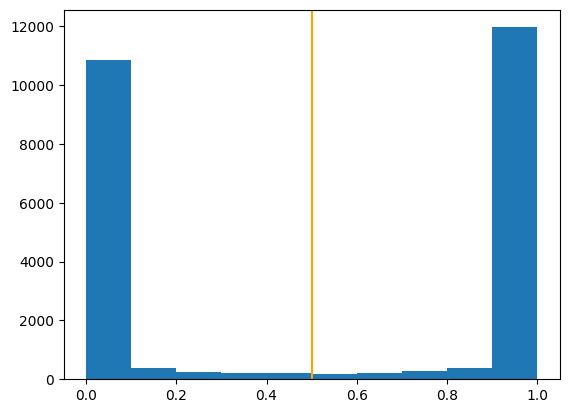

In [ ]:
plt.hist(y_pred)
_ = plt.axvline(x=0.5, color='orange')

Co widzimy? Model jest najczęściej bardzo zdecydowany, większość wartości znajduje się w skrajnych częściach wykresu. Pomarańczowa linia oznacza próg 0.5, powyżej którego model po prostu ocenia recenzję jako pozytywną. Spróbujmy jeszcze zatem na różne sposoby zbadać skuteczność klasyfikacji binarnej.

In [ ]:
roc_auc_score(y_valid, y_pred)*100.0

91.13238976

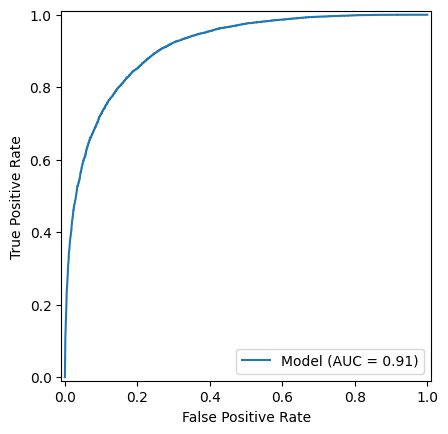

In [ ]:
fpr, tpr, thresholds = roc_curve(y_valid, y_pred)
roc_auc = auc(fpr, tpr)
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Model')
display.plot()
plt.show()

Krzywa roc wizualizuje zależność między skutecznością klasyfikacją próbek pozytywnych a nietrafnością klasyfikacji przypadków negatywnych (np. podział klientów banku na spłacających i niespłacających kredyty)

#### Zgromadźmy wyniki, np. w postaci DataFrame'a,

In [ ]:
float_y_pred = []
for y in y_pred:
    float_y_pred.append(y[0])
ydf = pd.DataFrame(list(zip(float_y_pred, y_valid)), columns=['y_pred', 'y'])
ydf.head(10)

,y_pred,y
0,3.529219e-03,0
1,9.999991e-01,1
2,9.694126e-01,1
3,5.561989e-01,0
4,1.000000e+00,1
5,9.987668e-01,1
6,9.989799e-01,1
7,1.722330e-07,0
8,9.993032e-01,0
9,9.960105e-01,1


**Zadanie 6. Wyświetl tę recenzję, która została błędnie zaklasyfikowana z największą nieprawidłową pewnością modelu (zauważ i weź pod uwagę, że jeśli wartość prawdopodobieństwa jest bardzo mała, to model również ma dużą pewność - że recenzja jest negatywna)**

In [ ]:
# 1. Obliczenie predykcji i binaryzacja
y_pred_flat = y_pred.ravel()
y_pred_binary = (y_pred_flat > 0.5).astype(int)

# 2. Znajdź błędne klasyfikacje
errors = (y_pred_binary != y_valid)  # Mask błędów
certainty = np.where(y_pred_binary == 1, y_pred_flat, 1 - y_pred_flat)  # Pewność modelu

# 3. Znajdź największą pewność błędnej klasyfikacji
most_confident_error_idx = np.argmax(certainty[errors])  # Indeks błędu o największej pewności
error_indices = np.where(errors)[0]  # Indeksy wszystkich błędów
review_idx = error_indices[most_confident_error_idx]

print(f"Indeks recenzji: {review_idx}")
print(f"Pewność modelu: {certainty[review_idx]:.4f}")
print(f"Rzeczywista etykieta: {y_valid[review_idx]}")
print(f"Predykcja modelu: {y_pred_binary[review_idx]}")

# 4. Odtwarzanie recenzji w formie tekstowej
word_index = imdb.get_word_index()
reverse_word_index = {value: key for key, value in word_index.items()}

decoded_review = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in x_valid[review_idx] if i > 2]
)

print("\nOryginalna recenzja:")
print(decoded_review)


Indeks recenzji: 740
Pewność modelu: 1.0000
Rzeczywista etykieta: 0
Predykcja modelu: 1

Oryginalna recenzja:
military century still war game raw look nuclear should required viewing punishment park its value well other than intended reason vision today example left full counter culture 70s paranoia given times vietnam state chicago 7 such seemed great distance truth 35 years later fever punishment park pretty silly ride
